In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from matplotlib import pyplot
import matplotlib.pyplot as plt

from prediction import LtrPrediction
from processing_transE import DataPreprocessing
import ltr_utils as ut

## Datasets

In [3]:
train = pd.read_csv("../Dataset/train.csv")
test = pd.read_csv("../Dataset/test.csv")
articles = pd.read_csv("../Dataset/Published_online_articles.csv")
users = pd.read_csv("../Dataset/subscribers.csv")

## Data Preprocessing

In [4]:
data_dict = {
    'train' : '../Dataset/train.csv',
    'test' : '../Dataset/test.csv',
    'articles' : '../Dataset/Published_online_articles.csv',
    'users' : '../Dataset/subscribers.csv'
}

In [5]:
DataPrep = DataPreprocessing(data_dict)

(11020, 19) (25672, 19)


In [6]:
DataPrep.init_KG('TransE/transE_combined_emb.txt')

In [7]:
DataPrep.init_SentenceTransformer('all-MiniLM-L6-v2')

In [8]:
train_data_df, test_data_df = DataPrep.fit_data_pipeline()

100%|██████████| 25672/25672 [18:29<00:00, 23.15it/s]
/home/devpil/anaconda3/envs/fid2_xgboost/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 11020/11020 [07:55<00:00, 23.15it/s]


In [9]:
processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg'])

87
(25672, 87) (25672, 1) (11020, 87) (11020, 1)


In [10]:
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

## Model Training

In [11]:
xgb_params = {  'booster':"gbtree", 
                'objective':"rank:pairwise",
                'tree_method':"gpu_hist", 
                'sampling_method':"gradient_based",
                'eval_metric':['map@10'],
             }

model = xgb.XGBRanker(**xgb_params)


model.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)

result = model.evals_result()
train_score = np.mean(result['validation_0']['map@10'])
test_score = np.mean(result['validation_1']['map@10'])
print('default Train :  ', train_score)
print('default Test  :  ', test_score)

default Train :   0.4058095483308847
default Test  :   0.17870518219766907


## Hyperparameter Tuning

In [12]:
def objective(trial):

        metric = "map@10"

        tuning_params = {
                    "max_depth": trial.suggest_int("max_depth", 2, 8, step=1),
                    "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.05),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.05),
                    "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0, step=0.01),
                    "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
                    "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 10.0, step=0.01),
                    "gamma": trial.suggest_float("gamma", 0.01, 10.0, step=0.01),
                    "max_delta_step":  trial.suggest_float("max_delta_step", 0.01, 10.0, step=0.01),
                    "eta": trial.suggest_float("eta", 0.001, 10.0, step=0.001)

                }
        
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-map@10")

        model = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                            tree_method="gpu_hist", sampling_method="gradient_based",
                            eval_metric=metric,
                            verbosity=1,
                            n_estimators=5000,
                            **tuning_params)

        model.fit(X_train, y_train, group=groups_train, eval_set=[(X_test, y_test)],early_stopping_rounds = 100,  eval_group=[groups_test], callbacks=[pruning_callback],  verbose=False)

        result = model.evals_result()
        opt_score1 = np.mean(result['validation_0'][metric])

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return opt_score1

# optuna.logging.WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=20)
study = optuna.create_study(pruner=pruner, direction='maximize')
study.optimize(objective, n_trials=500)

/home/devpil/anaconda3/envs/fid2_xgboost/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/devpil/anaconda3/envs/fid2_xgboost/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


In [14]:
print(f"Optimized MAP: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized MAP: 0.3107
Best params:
	max_depth: 3
	subsample: 0.55
	colsample_bytree: 0.75
	reg_lambda: 0.33
	alpha: 0.7026672253454432
	min_child_weight: 1.06
	gamma: 2.3499999999999996
	max_delta_step: 0.9
	eta: 0.001


In [15]:
metric = "map@10"

model_bst = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                        tree_method="gpu_hist", sampling_method="gradient_based",
                        eval_metric=metric,
                        n_estimators=5000,
                        early_stopping_rounds = 50, 
                        verbosity=0,
                        **study.best_params)

model_bst.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)
result = model_bst.evals_result()
train_score = np.max(result['validation_0']['map@10'])
test_score = np.max(result['validation_1']['map@10'])
print('Optimized Train :  ', train_score)
print('Optimized Test  :  ', test_score)

Optimized Train :   0.2365675231336474
Optimized Test  :   0.31930241090916806


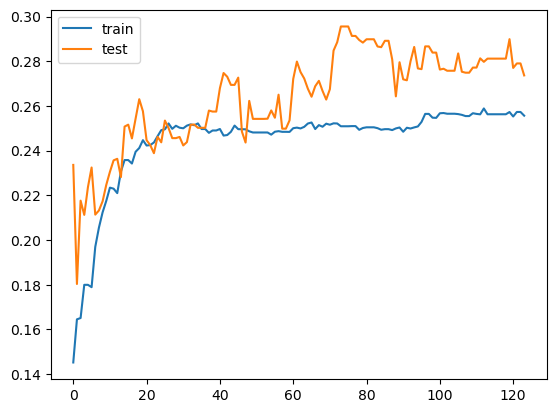

In [9]:
# plot learning curves
pyplot.plot(result['validation_0']['map@10'], label='train')
pyplot.plot(result['validation_1']['map@10'], label='test')
# show the legend
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (10,5)
# show the plot
pyplot.show()

In [16]:
path = 'outputs/kg_DP/'
ut.model_save(model_bst,path,DataPrep)

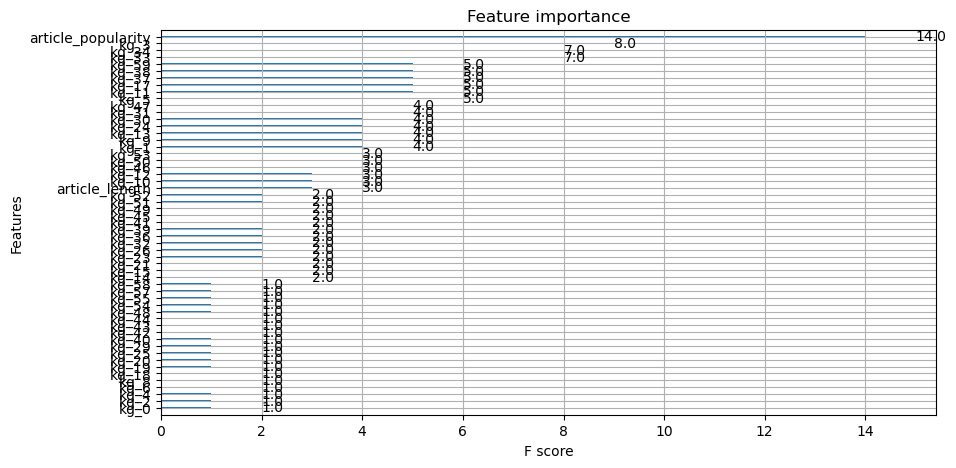

In [10]:
xgb.plot_importance(model_bst)
plt.show()

## Model Evaluation

In [2]:
path = 'outputs/kg_DP/'

model_bst, DataPrep = ut.load_model(path)

processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg'])
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

87
(25672, 87) (25672, 1) (11020, 87) (11020, 1)


In [3]:
xgb_Prediction = LtrPrediction(model_bst, test_data)

In [4]:
results = xgb_Prediction.evaluate()
results

NDCG=0.517 | Recall=0.712 | Precision=0.948 


{'MAP@10': 0.3582043321443804,
 'results@10': {'NDCG': 0.5166801374076652,
  'Recall': 0.7118087975931112,
  'Precision': 0.23355119825708062}}

In [5]:
top_k_best_score_ips = xgb_Prediction.get_recomendation()

In [6]:
tcm_le = DataPrep.return_inverse_transform()
top_k_best_score_ips['article_actual_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_actual']) ,axis=1)
top_k_best_score_ips['article_recomended_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_prediction']) ,axis=1)

In [7]:
pd.set_option('max_columns', None)
pd.set_option('display.max_colwidth', None)
top_k_best_score_ips[['article_actual_ids','article_recomended_ids','apk']].sort_values(by='apk',ascending = False).head(10)

,article_actual_ids,article_recomended_ids,apk
qid,,,
68235149,"[8410, 8987]","[8410, 8987, 4909, 5259, 3755, 9893, 2601, 517...",1.000000
17639664,"[8410, 8485, 6200, 9897]","[8485, 9897, 6200, 8410, 4909, 3755, 8987, 260...",1.000000
75566156,[2852],"[2852, 8410, 8987, 8962, 9893, 5742, 6200, 438...",1.000000
2570506,[9897],"[9897, 6184, 6200, 5788, 3755, 4909, 4326, 989...",1.000000
58147318,[6200],"[6200, 5788, 3755, 8987, 1073, 4326, 7387, 719...",1.000000
30229272,"[6184, 8410]","[8410, 6184, 6200, 8962, 3755, 9893, 8952, 423...",1.000000
43668861,"[8407, 8410]","[8407, 8410, 5742, 7197, 1226, 8952, 4234, 880...",1.000000
70342129,"[5788, 2229, 6184, 6200, 7387, 8410]","[8410, 6200, 6184, 5788, 9893, 7387, 2229, 260...",0.948413
69530129,"[1073, 2229, 7197, 8485, 4909]","[8485, 4909, 1073, 3755, 7197, 2229, 4380, 292...",0.926667


## SHAP

In [8]:
import shap

In [9]:
explainer = shap.Explainer(model_bst)
shap_values = explainer(X_train)

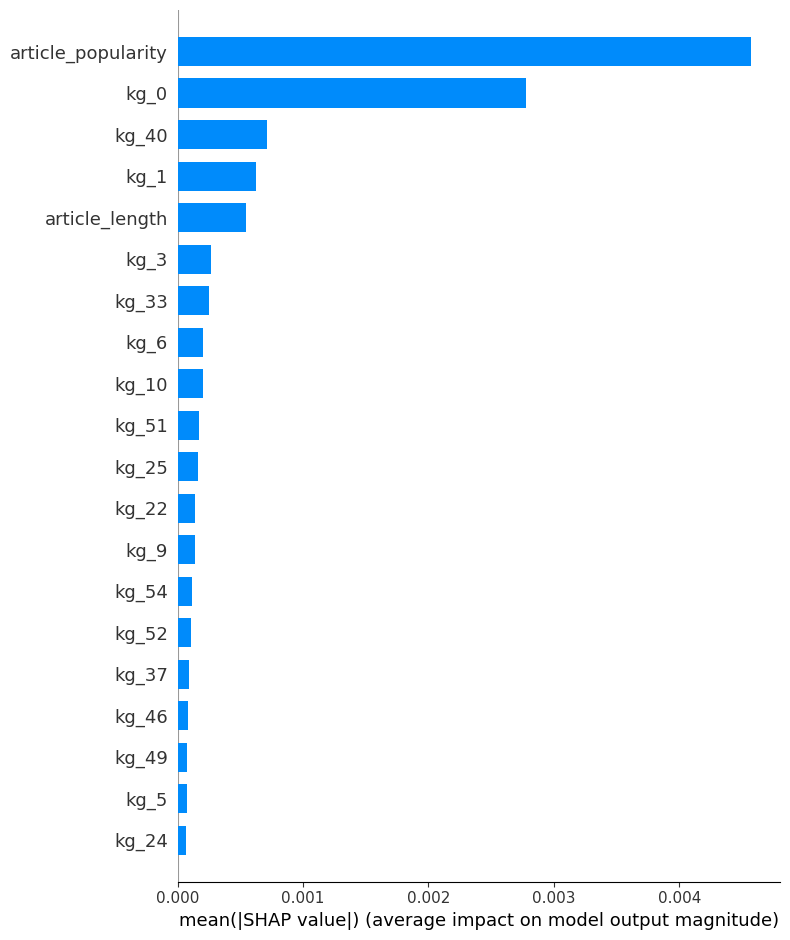

In [10]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## ELI5

In [11]:
from eli5.xgboost import explain_weights_xgboost

In [12]:
explain_weights_xgboost(model_bst)

Weight,Feature
0.0522,kg_0
0.0506,kg_3
0.0500,kg_7
0.0462,article_popularity
0.0435,kg_10
0.0424,kg_22
0.0422,article_length
0.0416,kg_5
0.0373,kg_33
0.0339,kg_25
